# 利用专家知识

对于特定应用来说，在特征工程中通常可以利用专家知识(expert knowledge)。虽然在许多情况下，机器学习的目的是避免创建一组专家设计的规则，但这并不意味着应该舍弃该应用或该领域的先验知识。通常来说，领域专家可以帮助找出有用的特征，其信息量比数据原始表示要大得多。

据原始表示要大得多。想象一下，你在一家旅行社工作，想要预测机票价格。假设你有价格以及日期、航空公司、出发地和目的地的记录。机器学习模型可能从这些记录中构建个相当不错的模型，但可能无法学到机票价格中的某些重要因素。例如，在度假高峰月份和假日期间，机票价格通常更高。虽然某些假日的日期是固定的(比如圣诞节)，其影响可以从日期中学到，但其他假目的日期可能取决于月相(比如光明节和复活节)，或者由官方规定(比如学校放假)。如果每个航班都只使用公历记录日期，则无法从数据中学到这些事件。但添加一个特征是很简单的，其中编码了一个航班在公休假日或学校假期的之前、之中还是之后。利用这种方法可以将关于任务属性的先验知识编码到特征中，以辅助机器学习算法。添加一个特征并不会强制机器学习算法使用它，即使最终发现假日信息不包含关于机票价格的信息，用这一信息来扩充数据也不会有什么害处。

下面我们来看一个利用专家知识的特例一虽然在这个例子中，对这些专家知识更正确的叫法应该是“常识”。任务是预测在 Andreas 家门口的自行车出租。在纽约，Citi Bike 运营着一个带有付费系统的自行车租赁站网络。这些站点遍布整个城市提供了一种方便的交通方式。自行车出租数据以匿名形式公开，并用各种方法进行了分析。我们想要解决的任务是，对于给定的日期和时间，预测有多少人将会在 Andreas 的家门口租一辆自行车一一这样他就知道是否还有自行车留给他。

我们首先将这个站点2015年8月的数据加载为一个pandas 数据框。我们将数据重新采样为每3小时一个数据，以得到每一天的主要趋势:

In [1]:
import mglearn
citibike = mglearn.datasets.load_citibike()
print("Citi bike data:\n {}".format(citibike.head()))

Citi bike data:
 starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


下面这个示例给出了整个月租车数量的可视化

Text(0, 0.5, 'Rentals')

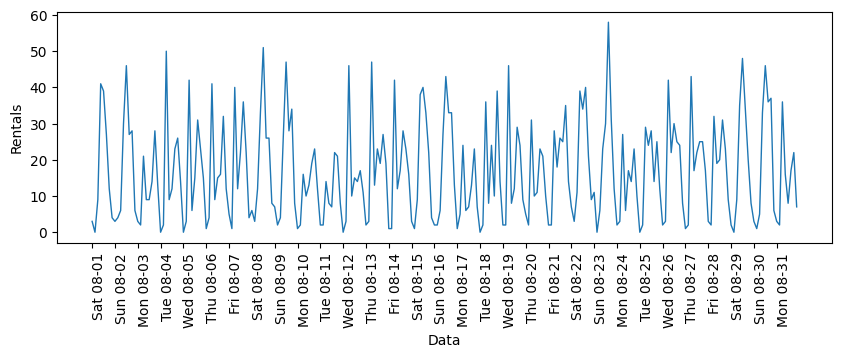

In [2]:
# 对于选定的CitiBike站点，自行车出租数量随时间的变化
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10,3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Data")
plt.ylabel("Rentals")



观察此数据，我们可以清楚地区分每 24小时中的白天和夜间。工作日和周末的模式似乎也有很大不同。在对这种时间序列上的预测任务进行评估时，我们通常希望从过去学习并预测未来。也就是说，在划分训练集和测试集的时候，我们希望使用某个特定日期之前的所有数据作为训练集，该日期之后的所有数据作为测试集。这是我们通常使用时间序列预测的方式:已知过去所有的出租数据，我们认为明天会发生什么?我们将使用前 184 个数据点(对应前 23 天)作为训练集，剩余的64 个数据点 (对应剩余的8天)作为测试集。

在我们的预测任务中，我们使用的唯一特征就是某一租车数量对应的日期和时间。因此输入特征是日期和时间，比如2015-08-01 00:00:00，而输出是在接下来3小时内的租车数量

在计算机上存储日期的常用方式是使用 POSIX时间(这有些令人意外)，它是从 1970年1月1日00:00:00(也就是 Unix 时间的起点)起至现在的总秒数。首先，我们可以尝试使用这个单一整数特征作为数据表示:

In [3]:
# 提取目标值（租车数量）
y = citibike.values
# 利用“%s”将时间转换为POSIX时间
X = citibike.index.astype("int64").values.reshape(-1, 1)
# reshape(-1, 1) 的用法经常用于将数组转换为一个列向量。这意味着你希望将数组重新组织为两维，
#其中第一个维度的大小是未知的（由 -1 表示），
#而第二个维度的大小为1。
# 这通常用于将一维数组转换为列向量。

我们首先定义一个函数，它可以将数据划分为训练集和测试集，构建模型并将结果可视化:

In [4]:
# 使用前184个数据点用于训练，剩余的数据点用于测试
n_train = 184
# 对给定的特征集上的回归进行评估和作图的函数
def eval_on_features(features, target, regressor):
    # 将给定的特征划分为训练集和测试集
    X_train, X_test = features[:n_train], features[n_train:]
    # 同样划分目标数组
    y_train, y_test = target[: n_train], target[n_train: ]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize=(10,3))
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,ha="left")
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")
    

我们之前看到，随机森林需要很少的数据预处理，因此它似乎很适合作为第一个模型。我们使用POSIX时间特征X，并将随机森林回归传入我们的eval_on_features 函数。结果如图所示。

Test-set R^2: -0.04


<Figure size 640x480 with 0 Axes>

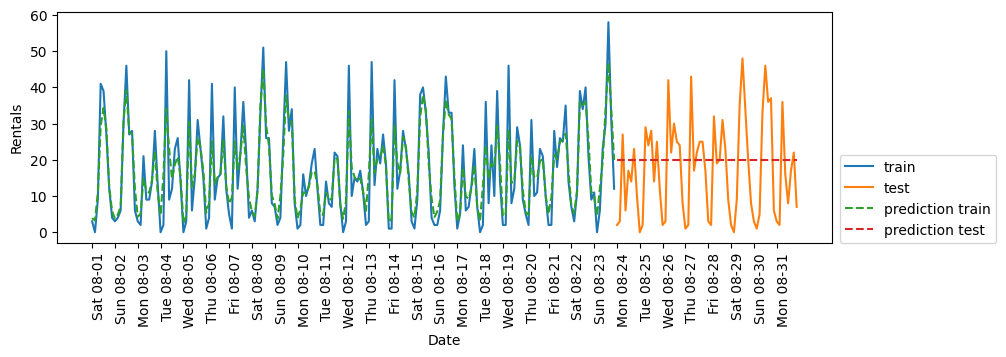

In [5]:
# 随机森林仅使用POSIX时间做出的预测
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
eval_on_features(X, y, regressor)

在训练集上的预测结果相当好，这符合随机森林通常的表现。但对于测试集来说，预测结果是一条常数直线。R’为 -0.04，说明我们什么都没有学到。发生了什么?

问题在于特征和随机森林的组合。测试集中 POSIX 时间特征的值超出了训练集中特征取值的范围:测试集中数据点的时间戳要晚于训练集中的所有数据点。树以及随机森林无法**外推**(extrapolate)到训练集之外的特征范围。结果就是模型只能预测训练集中最近数据点的目标值，即最后一次观测到数据的时间。

显然，我们可以做得更好。这就是我们的“专家知识”的用武之地。通过观察训练数据中的租车数量图像，我们发现两个因素似乎非常重要:一天内的时间与一周的星期几。因此我们来添加这两个特征。我们从POSIX时间中学不到任何东西，所以删掉这个特征。首先，我们仅使用每天的时刻。如图所示，现在的预测结果对一周内的每天都具有相同的模式:

Test-set R^2: 0.60


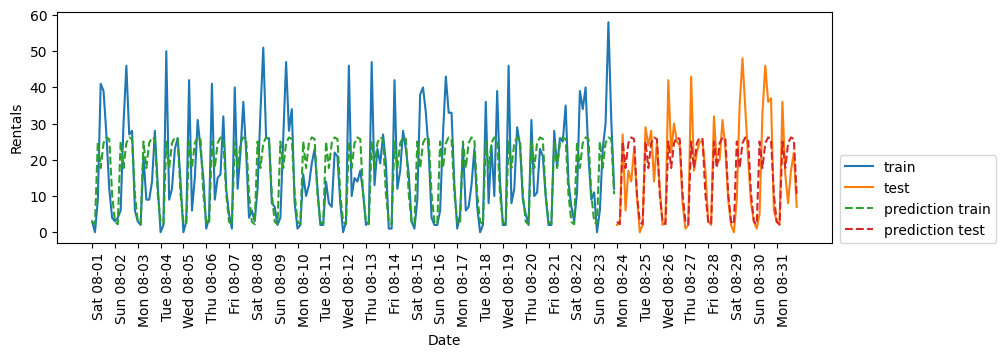

In [6]:
# 随机森林仅使用每天的时刻做出的预测
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

R^2已经好多了，但预测结果显然没有抓住每周的模式。下面我们还添加一周的星期几作为特征:

Test-set R^2: 0.84


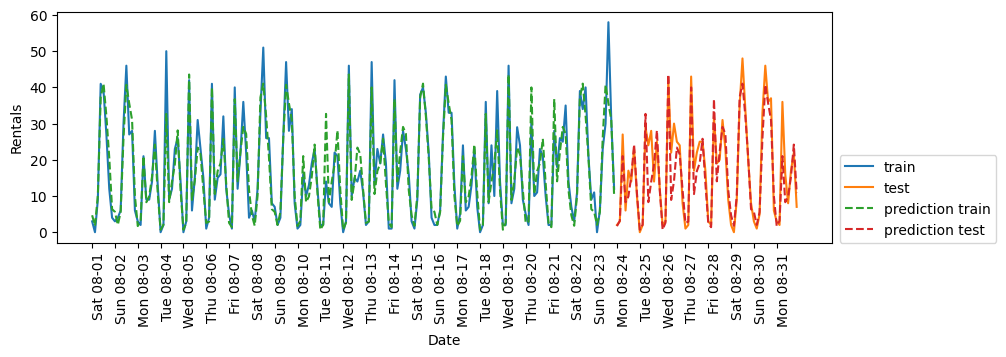

In [7]:
# 随机森林使用一周的星期几和每天的时刻两个特征做出的预测
import numpy as np
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

现在我们的模型通过考虑一周的星期几和一天内的时间捕捉到了周期性的行为。它的 R为0.84，预测性能相当好。模型学到的内容可能是8月前23 天中星期几与时刻每种组合的平均租车数量。这实际上不需要像随机森林这样复杂的模型，所以我们尝试一个更简单的模型一LinearRegression

Test-set R^2: 0.13


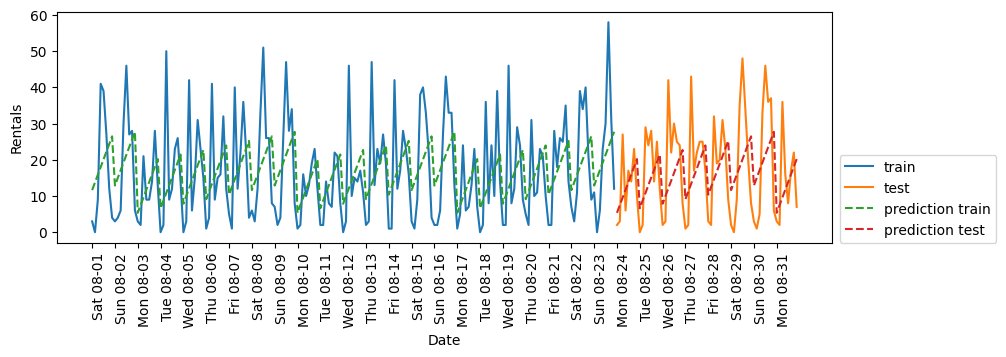

In [8]:
# 线性模型使用一周的星期几和每天的时刻两个特征做出的预测
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
eval_on_features(X_hour_week, y, regressor)

LinearRegression 的效果差得多，而且周期性模式看起来很奇怪。其原因在于我们用整数编码一周的星期几和一天内的时间，它们被解释为连续变量。因此，线性模型只能学到关于每天时间的线性函数一一它学到的是，时间越晚，租车数量越多。但实际模式比这要复杂得多。我们可以通过将整数解释为分类变量 (用OneHotEncoder 进行变换) 来获取这种模式

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Test-set R^2: 0.62


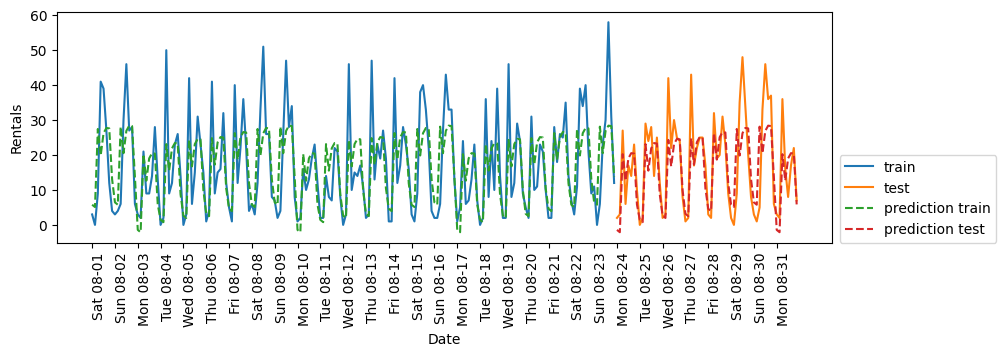

In [10]:
# 线性模型使用one-hot编码过的一周的星期几和每天的时刻两个特征做出的预测
eval_on_features(X_hour_week_onehot, y, Ridge())

它给出了比连续特征编码好得多的匹配。现在线性模型为一周内的每天都学到了一个系数，为一天内的每个时刻都学到了一个系数。也就是说，一周七天共享“一天内每个时刻”的模式。

利用交互特征，我们可以让模型为星期几和时刻的每一种组合学到一个系数

Test-set R^2: 0.85


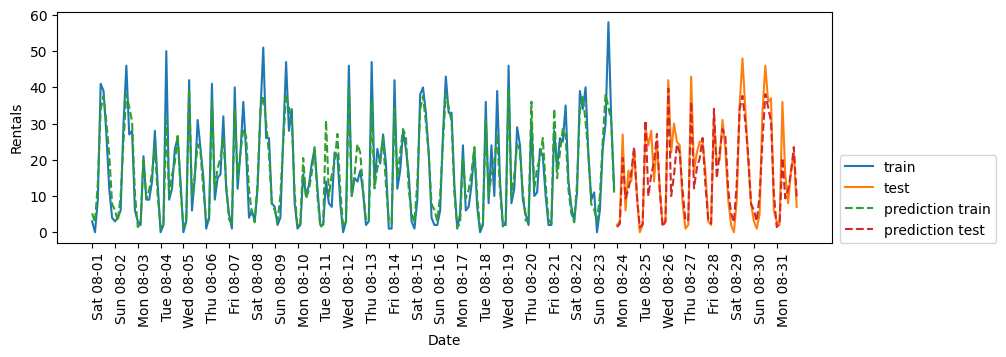

In [11]:
# 线性模型使用星期几和时刻两个特征的乘积做出的预测
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)                        # 多项式
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

这一变换最终得到一个性能与随机森林类似的模型。这个模型的一大优点是，可以很清楚地看到学到的内容:对每个星期几和时刻的交互项学到了一个系数。我们可以将模型学到的系数作图，而这对于随机森林来说是不可能的。

首先，为时刻和星期几特征创建特征名称

In [12]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features =  day + hour

然后，利用get_feature_names 方法对 PolynomialFeatures 提取的所有交互特征进行命名并仅保留系数不为零的那些特征:

In [13]:
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

下面将线性模型学到的系数可视化

Text(0, 0.5, 'Feature magnitude')

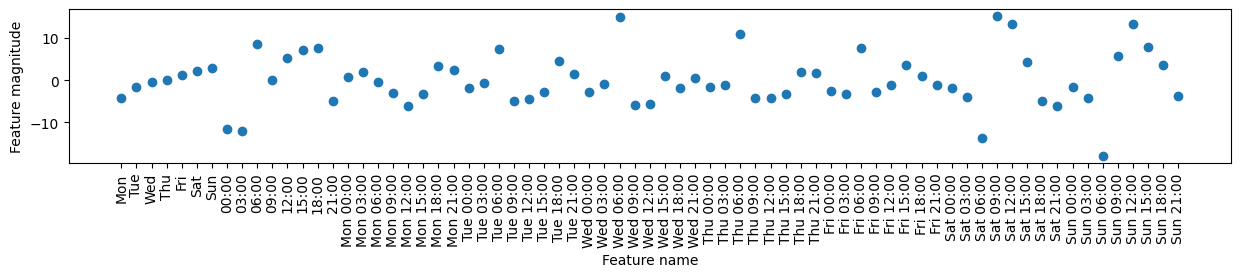

In [14]:
# 线性模型使用星期几和时刻两个特征的乘积学到的系数
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")